<a href="https://colab.research.google.com/github/MatheusFidelisPE/Projeto-AR/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main.ipynb)

# Tema 8 - Estudo de parâmetros com ambientes diversos

Os algoritmos de aprendizagem possuem uma característica interessante, que é a capacidade de mudança de uma execução para outra após alterar minimamente um parâmetro do modelo. Assim, o trabalho atual busca testar diferentes valores para importantes parâmetros ** epsilon, número de passos, gamma, alfa e taxa de aprendizagem**.

Treinaremos o agente por **N** episódios, após isso faremos a execução de **M** episódios focando na recompensa obtida durante a execução dos M episódios. Para reduzir reduzir o fator aleatório, faremos a execução dos M episódios **X** vezes para calcular a média dessas recompensas e o desvio padrão.



## Configurações Iniciais

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [2]:
# Imports importantes para criação dos algoritmos, exeução e apresentação dos gráficos e outros valores.
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import matplotlib.pyplot as plt
import numpy as np
import os
from cap06.nstep_sarsa import run_nstep_sarsa

from envs import RacetrackEnv
from envs.wrappers import ObservationDiscretizerWrapper

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable

## Sarsa personalizado para treinar e testar

In [3]:
from util.qtable_helper import epsilon_greedy
from collections import deque
import gymnasium as gym
import numpy as np

def run_nstep_sarsa_by_eps(env, episodes, nsteps=1, lr=0.1, gamma=0.95, epsilon=0.1, verbose=False,**kargs):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    assert isinstance(nsteps, int)

    num_actions = env.action_space.n
    mode = ""
    if kargs.get("mode", None) == "compare":
      mode = "compare"

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    if kargs.get("Q", None) is None:
      Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))
    # Em caso de teste, a tabela Q já é carregada
    else:
      Q = kargs["Q"].copy()
    gamma_array = np.array([ gamma**i for i in range(0,nsteps)])
    gamma_power_nstep = gamma**nsteps

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        # escolhe a próxima ação
        action = epsilon_greedy(Q, state, epsilon)

        # históricos de: estados, ações e recompensas
        hs = deque(maxlen=nsteps)
        ha = deque(maxlen=nsteps)
        hr = deque(maxlen=nsteps)

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # realiza a ação
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sum_rewards += reward

            # escolhe (antecipadamente) a ação do próximo estado
            next_action = epsilon_greedy(Q, next_state, epsilon)

            hs.append(state)
            ha.append(action)
            hr.append(reward)

            # se o histórico estiver completo com 'n' passos
            # vai fazer uma atualização no valor Q do estado mais antigo
            if len(hs) == nsteps:
                if terminated:
                    # para estados terminais
                    V_next_state = 0
                else:
                    # para estados não-terminais -- valor da próxima ação (já escolhida)
                    V_next_state = Q[next_state,next_action]

                # delta = (estimativa usando a nova recompensa) - estimativa antiga
                delta = ( sum(gamma_array * hr) + gamma_power_nstep * V_next_state ) - Q[hs[0],ha[0]]

                # atualiza a Q-table para o par (estado,ação) de n passos atrás
                Q[hs[0],ha[0]] += lr * delta

            # preparação para avançar mais um passo
            # lembrar que a ação a ser realizada já está escolhida
            state = next_state
            action = next_action
            # fim do laço por episódio

        # ao fim do episódio, atualiza o Q dos estados que restaram no histórico

        # é igual ao V_next_state, exceto em episódios muito curtos (com duração menor que "nsteps")
        V_end_state = 0 if terminated else Q[next_state,next_action]

        # inferior ao "nsteps" apenas em episódios muito curtos
        steps_to_end = min(nsteps, len(hs))
        for j in range(steps_to_end-1,0,-1):
            hs.popleft()
            ha.popleft()
            hr.popleft()
            delta = ( sum(gamma_array[0:j]*hr) + gamma_array[j]*V_end_state ) - Q[hs[0],ha[0]]
            Q[hs[0],ha[0]] += lr * delta

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    if mode == "compare":
      last_hundred = np.mean(sum_rewards_per_ep[-100:])
      return last_hundred, None

    return sum_rewards_per_ep, Q

## Funções de execução de teste e treinamento
* vary_nsteps : Variação dos valores de passos
* vary_LR : Variação dos valores de LR
* vary_EPSILON: Variação dos valores de Epsilon
* vary_GAMMA: Variação dos valores de gamma






In [4]:
def vary_nsteps(env, values_list:list,number_of_executions, **kargs):

  #setup aplicação
  EPISODES = kargs["EPISODES"]
  LR = kargs["LR"]
  GAMMA = kargs["GAMMA"]
  EPSILON = kargs["EPSILON"]

  #Escolher imprimir ou não
  verbose = kargs["verbose"]

  #Estruturas de dados para armazenamento
  dict_of_each_parameter = dict()

  for nsteps in values_list:
    # Treinar o modelo
    dict_of_each_parameter[nsteps] = list()
    if verbose:
      print(f"Treinando com {nsteps} passos")
    rewards_training, Q = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=LR, gamma=GAMMA, epsilon=EPSILON, verbose=verbose)
    for i in range(number_of_executions):
      clear_output()
      print(i)
      if verbose:
        print(f"Rodando experimento {i+1} de {nsteps} passos")

      rewards_test, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=LR, gamma=GAMMA, epsilon=EPSILON, verbose=verbose, Q=Q)
      dict_of_each_parameter[nsteps].append(rewards_test)

  return dict_of_each_parameter


def vary_LR(env, values_list:list,number_of_executions, **kargs):

  #setup aplicação
  EPISODES = kargs["EPISODES"]
  GAMMA = kargs["GAMMA"]
  EPSILON = kargs["EPSILON"]
  #Escolher imprimir ou não
  verbose = kargs["verbose"]

  #Estruturas de dados para armazenamento
  dict_of_each_parameter = dict()

  for lr in values_list:
    # Treinar o modelo
    dict_of_each_parameter[lr] = list()
    if verbose:
      print(f"Treinando com {lr} passos")
    rewards_training, Q = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=lr, gamma=GAMMA, epsilon=EPSILON, verbose=verbose)
    for i in range(number_of_executions):
      clear_output()
      print(i)
      if verbose:
        print(f"Rodando experimento {i+1} de {lr} passos")

      rewards_test, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=lr, gamma=GAMMA, epsilon=EPSILON, verbose=verbose, Q=Q)
      dict_of_each_parameter[lr].append(rewards_test)



  return dict_of_each_parameter

def vary_EPSILON(env, values_list:list,number_of_executions, **kargs):

  #setup aplicação
  EPISODES = kargs["EPISODES"]
  GAMMA = kargs["GAMMA"]
  LR = kargs["LR"]
  #Escolher imprimir ou não
  verbose = kargs["verbose"]

  #Estruturas de dados para armazenamento
  dict_of_each_parameter = dict()

  for epsilon in values_list:
    # Treinar o modelo
    dict_of_each_parameter[epsilon] = list()
    if verbose:
      print(f"Treinando com {epsilon} passos")
    rewards_training, Q = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=LR, gamma=GAMMA, epsilon=epsilon, verbose=verbose)
    for i in range(number_of_executions):
      clear_output()
      print(i)
      if verbose:
        print(f"Rodando experimento {i+1} de {epsilon} passos")

      rewards_test, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=LR, gamma=GAMMA, epsilon=epsilon, verbose=verbose, Q=Q)
      dict_of_each_parameter[epsilon].append(rewards_test)



  return dict_of_each_parameter


def vary_GAMMA(env, values_list:list,number_of_executions, **kargs):
  #setup aplicação
  EPISODES = kargs["EPISODES"]
  LR = kargs["LR"]
  EPSILON = kargs["EPSILON"]
  #Escolher imprimir ou não
  verbose = kargs["verbose"]

  #Estruturas de dados para armazenamento
  dict_of_each_parameter = dict()

  for gamma in values_list:
    # Treinar o modelo
    dict_of_each_parameter[gamma] = list()
    if verbose:
      print(f"Treinando com {gamma} passos")
    rewards_training, Q = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=LR, gamma=gamma, epsilon=EPSILON, verbose=verbose)
    for i in range(number_of_executions):
      clear_output()
      print(i)
      if verbose:
        print(f"Rodando experimento {i+1} de {gamma} passos")

      rewards_test, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=NSTEPS, lr=LR, gamma=gamma, epsilon=EPSILON, verbose=verbose, Q=Q)
      dict_of_each_parameter[gamma].append(rewards_test)



  return dict_of_each_parameter


### Função experiment é utilizada para rodar todos os experimentos que temos interesse em testar, ou seja, variação de gamma, epsilon, lr e nsteps

In [5]:
def experiment(env, env_name:str, window, pasta):
  rewards_gamma = vary_GAMMA(env, GAMMA_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR, EPSILON=EPSILON, verbose=False, EPISODES=EPISODES, NSTEPS=NSTEPS)
  criar_graficos(rewards_gamma, GAMMA_RAND, "Gamma", env_name, window, pasta)
  rewards_epsilon = vary_EPSILON(env, EPSILON_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR,GAMMA=GAMMA, verbose=False, EPISODES=EPISODES, NSTEPS=NSTEPS)
  criar_graficos(rewards_epsilon, EPSILON_RAND, "Epsilon", env_name,window,pasta)
  rewards_lr = vary_LR(env, LR_RAND, ITERATIONS_TO_CALCULATE_MEAN, GAMMA=GAMMA, EPSILON=EPSILON, verbose=False, EPISODES=EPISODES, NSTEPS=NSTEPS)
  criar_graficos(rewards_lr, LR_RAND, "Lr", env_name, window, pasta)
  rewards_nsteps = vary_nsteps(env, NSTEPS_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR, GAMMA=GAMMA, EPSILON=EPSILON, verbose=False, EPISODES=EPISODES)
  criar_graficos(rewards_nsteps, NSTEPS_RAND, "Nsteps", env_name, window, pasta)

  return rewards_gamma, rewards_epsilon, rewards_lr, rewards_nsteps

### Funções para criar os gráficos de avaliação. A função smooth é utilizada para suavizar as variações existentes no gráfico e assim tornar a informação mais simples de ver


In [6]:
def smooth(data, window):
  data = np.array(data)
  n = len(data)
  y = np.zeros(n)
  for i in range(n):
    start = max(0, i-window+1)
    y[i] = data[start:(i+1)].mean()
  return y


def criar_graficos(rewards, values_list, parameter, env_name, window, pasta):
  values_list.sort()
  for value in values_list:
    rewards_per_parameter = rewards[value]

    rewards_mean = np.mean(rewards_per_parameter, axis=0)
    rewards_mean = smooth(rewards_mean, window)

    rewards_std = np.std(rewards_per_parameter, axis=0)
    rewards_std = smooth(rewards_std, window)

    x = np.arange(len(rewards_mean))
    y = rewards_mean # Média
    std_dev = rewards_std

# Criar o gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label="Média", color="blue")
    plt.fill_between(x, y - std_dev, y + std_dev, color="blue", alpha=0.2, label="Desvio padrão")

# Adicionar rótulos e legenda
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Gráfico com Média e Desvio Padrão {parameter}:{value}")
    plt.legend()
    plt.grid(True)


    folder_path = f"/content/drive/MyDrive/graphs/{pasta}/"

  # Verifica se a pasta existe, se não, cria
    if not os.path.exists(folder_path):
      os.makedirs(folder_path)
    # Salvar a figura
    plt.savefig(f"/content/drive/MyDrive/graphs/{pasta}/{env_name}_{parameter}_{value}.png", dpi=300, bbox_inches="tight")

In [7]:
def plot_multiple_results(list_returns, cumulative='no', x_log_scale=False, x_axis='episode', window=10, plot_stddev=False, yreference=None, y_min=None, **kargs):
    '''Exibe um gráfico "episódio/passo x retorno" com vários resultados.

    Parâmetros:
    - list_returns: uma lista de pares (nome do resultado, retorno por episódio/passo)
    - cumulative: indica se as recompensas anteriores devem ser acumuladas, para calcular a soma ou média histórica por episódio
    - x_log_scale: se for True, mostra o eixo x na escala log (para detalhar mais os resultados iniciais)
    - x_axis: use 'episode' ou 'step' para indicar o que representa o eixo x
    - window: permite fazer a média dos últimos resultados, para suavizar o gráfico; só é usado se cumulative='no'
    - plot_stddev: exibe sombra com o desvio padrão, ou seja, entre média-desvio e média+desvio
    - yreference: if not None, should be an integer, where will be plot a horizontal gray dashed line, used for reference
    - y_min: valor mínimo do eixo y; caso os dados tenham valor menor, o gráfico será ajustado para adotar este valor como mínimo
    '''
    # True and False are here for backward compatibility (remove!)
    if cumulative is None:
        cumulative = 'no'
    assert cumulative in ['no', 'sum', 'avg']
    # assert x_axis in ['step', 'episode', 'hyperparam']

    total_steps = list_returns[0][1].shape[1]
    plt.figure(figsize=(12,7))

    if kargs.get("xvalues",None) is not None:
      xvalues = kargs["xvalues"]
    else:
      xvalues = None
    for (alg_name, returns) in list_returns:
        xvalues = np.arange(1, total_steps+1) if xvalues is None else xvalues
        # TODO: bug -- isso está errado para cumulative='avg', quando x_axis='step'
        if cumulative == 'sum' or cumulative == 'avg':
            # calculate the cumulative sum along axis 1
            cumreturns = np.cumsum(returns, axis=1)
            if cumulative == 'avg':
                cumreturns = cumreturns / xvalues
            yvalues = cumreturns.mean(axis=0)
            std = cumreturns.std(axis=0)
        else:
            yvalues = smooth(returns.mean(axis=0),window)
            std = returns.std(axis=0)
        plt.plot(xvalues, yvalues, label=alg_name)
        if plot_stddev:
            plt.fill_between(xvalues, yvalues-std, yvalues+std, alpha=0.4)

    if yreference is not None:
        y_ref_line = [ yreference ] * total_steps
        plt.plot(y_ref_line, linestyle="--", color="gray")

    if x_log_scale:
        plt.xscale('log')

    if x_axis == 'episode':
        plt.xlabel('Episodio')
        payoff = 'Retorno'
    elif x_axis == 'step':
        plt.xlabel('Passo')
        payoff = 'Recompensa'
    elif x_axis == 'Alfa':
        plt.xlabel('Alfa')
        payoff = 'Recompensa'
    elif x_axis == 'Epsilon':
        plt.xlabel('Epsilon')
        payoff = 'Recompensa'
    else:
      plt.xlabel('Episodio')
      payoff = 'Retorno'

    plt.ylabel('Retorno')

    if cumulative == 'no':
        plt.title(f"{payoff} (média móvel a cada {window})")
    elif cumulative == 'avg':
        gen = payoff[-1]
        plt.title(f"{payoff} acumulad{gen} médi{gen}")
    else:
        gen = payoff[-1]
        plt.title(f"{payoff} acumulad{gen}")

    if y_min is not None:
        min_value = min(np.min(returns) for (_, returns) in list_returns)
        if min_value < y_min:
            plt.ylim(bottom=y_min)

    plt.legend()
    plt.show()

## Execuções dos experimentos

### 1.1 Experimento: Utilizando o ambiente RaceTrack
- Alterando LR



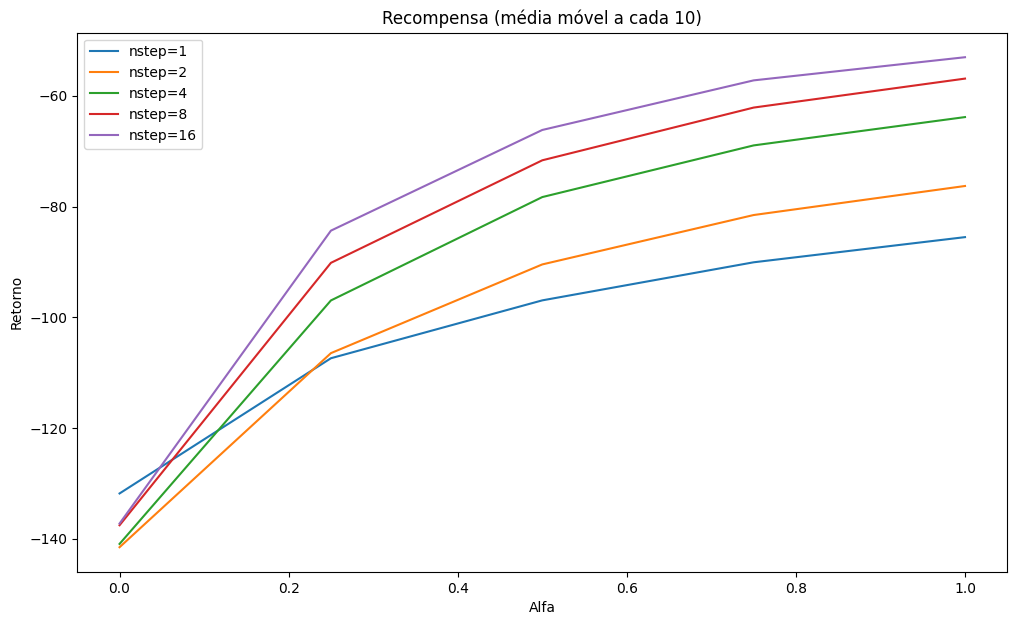

In [ ]:
import numpy as np
# from util.plot import plot_multiple_results

# Para todos
ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

ENV_NAME, r_max = "RaceTrack-v0", 0
env = gym.make(ENV_NAME)


lr_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]
lr_list, NSTEPS_FOR_COMPARISON

results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for lr in lr_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=lr, gamma=0.95, epsilon=0.1, verbose=False,mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {lr}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Alfa", xvalues=lr_list)

### 1.2 Experimento: Utilizando o ambiente RaceTrack



- Alterando EPSILON


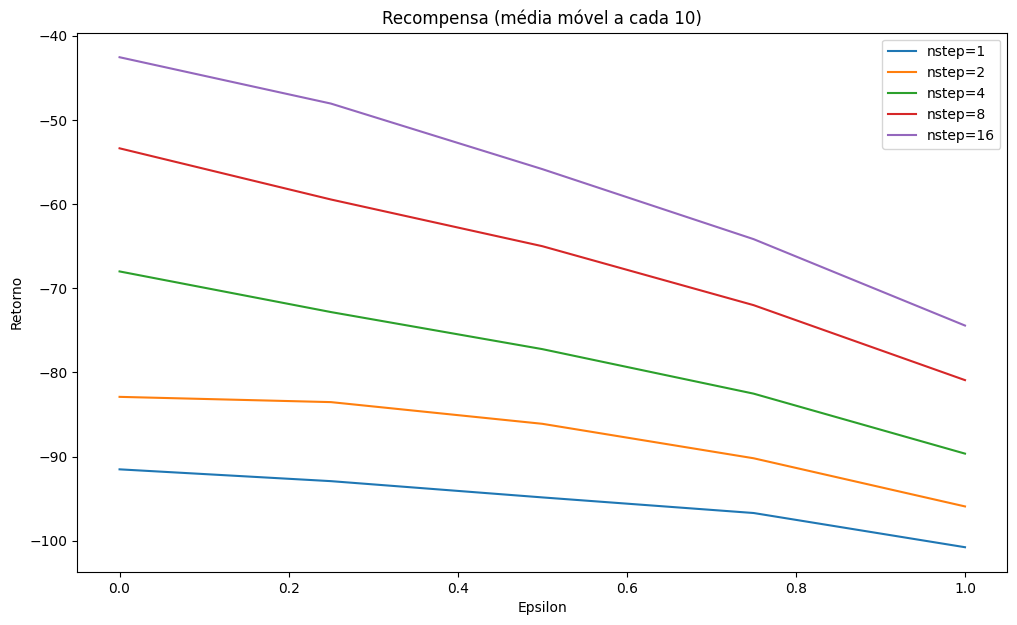

In [ ]:
import numpy as np
# from util.plot import plot_multiple_results

# Para todos
ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

ENV_NAME, r_max = "RaceTrack-v0", 0
env = gym.make(ENV_NAME)


epsilon_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]


results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for epsilon in epsilon_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=0.1, gamma=0.95, epsilon=epsilon, verbose=False, mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {epsilon}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Epsilon", xvalues=epsilon_list)

### Experimento 2: Utilizando o ambiente Frozen Lake

### 2.1 Experimento: Utilizando o ambiente FrozenLake

- Alterando Alfa

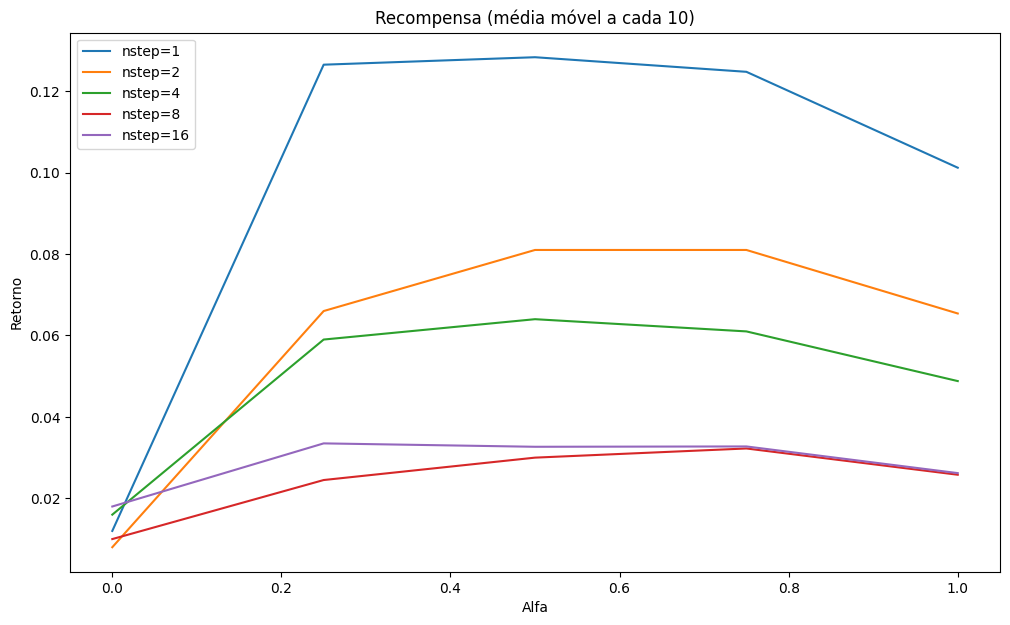

In [11]:
ENV_NAME, r_max = "FrozenLake-v1", 0

ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

env = gym.make(ENV_NAME)


lr_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]
lr_list, NSTEPS_FOR_COMPARISON

results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for lr in lr_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=lr, gamma=0.95, epsilon=0.1, verbose=False,mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {lr}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Alfa", xvalues=lr_list)

### 2.2 Experimento: Utilizando o ambiente FrozenLake

- Alterando EPSILON


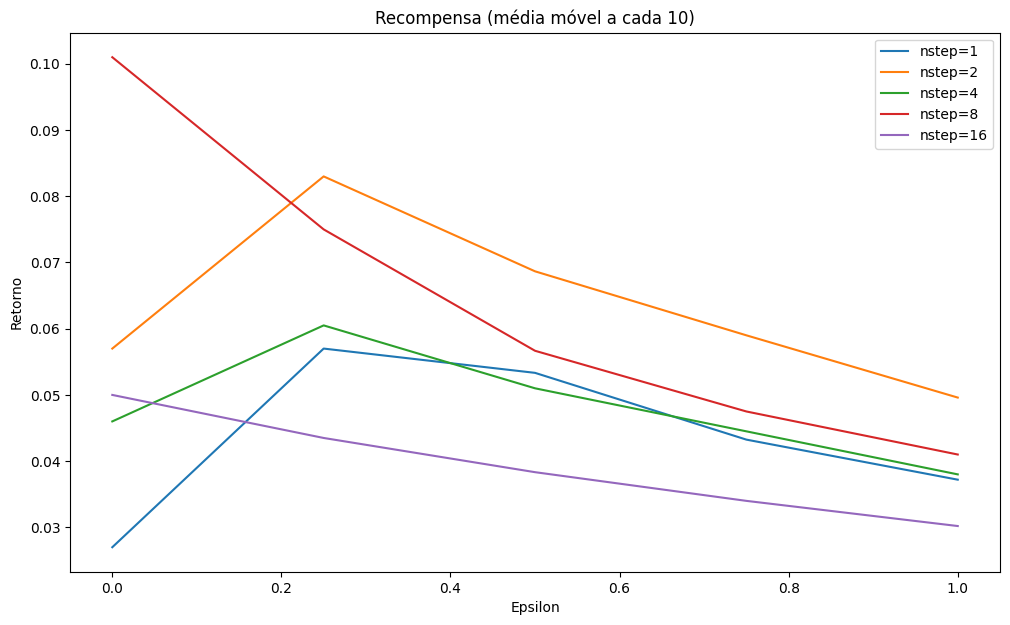

In [10]:
ENV_NAME, r_max = "FrozenLake-v1", 0

ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

env = gym.make(ENV_NAME)


epsilon_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]


results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for epsilon in epsilon_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=0.1, gamma=0.95, epsilon=epsilon, verbose=False, mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {epsilon}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Epsilon", xvalues=epsilon_list)

### 3. Experimento: Utilizando o ambiente Cliff Walking

### 3.1 Experimento utilizando o ambiente CLiff Walking
- Alterando Alfa

In [ ]:
ENV_NAME, r_max = "CliffWalking-v0", 0

ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

env = gym.make(ENV_NAME)


lr_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]
lr_list, NSTEPS_FOR_COMPARISON

results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for lr in lr_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=lr, gamma=0.95, epsilon=0.1, verbose=False,mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {lr}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Alfa", xvalues=lr_list)

### 3.2 Experimento Utilizando o ambiente Cliff Walking
- Alterando o Epsilon

In [ ]:
ENV_NAME, r_max = "CliffWalking-v0", 0

ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 1_000
NUM_HYPERPARAM = 5
NUM_STEPS = 5

env = gym.make(ENV_NAME)


epsilon_list = np.linspace(0.0, 1, NUM_HYPERPARAM)
NSTEPS_FOR_COMPARISON = [2**x for x in range(NUM_STEPS)]


results_list = []
for nsteps in NSTEPS_FOR_COMPARISON:
  temporary_list = []
  for epsilon in epsilon_list:
    soma = 0
    for i in range(ITERATIONS_TO_CALCULATE_MEAN):
      retorno, _ = run_nstep_sarsa_by_eps(env, EPISODES, nsteps=nsteps, lr=0.1, gamma=0.95, epsilon=epsilon, verbose=False, mode="compare")
      soma += retorno

    mean = soma/ITERATIONS_TO_CALCULATE_MEAN
    print(f'{nsteps}, {epsilon}, {soma}, {mean}')
    temporary_list.append(mean)
  results_list.append((f'nstep={nsteps}', np.array(temporary_list).reshape(1, -1)))

clear_output()

plot_multiple_results(results_list,x_axis="Epsilon", xvalues=epsilon_list)

### Experimento 4: Utilizando o ambiente Taxi

9
Episode 100 Average Reward (last 100): -0.170
Episode 200 Average Reward (last 100): 0.360
Episode 300 Average Reward (last 100): 0.650
Episode 400 Average Reward (last 100): -0.310
Episode 500 Average Reward (last 100): -0.380
Episode 600 Average Reward (last 100): 0.340
Episode 700 Average Reward (last 100): 0.640
Episode 800 Average Reward (last 100): 1.670
Episode 900 Average Reward (last 100): 1.810
Episode 1000 Average Reward (last 100): 0.520
Episode 1100 Average Reward (last 100): 0.370
Episode 1200 Average Reward (last 100): 0.590
Episode 1300 Average Reward (last 100): -0.740
Episode 1400 Average Reward (last 100): -0.750
Episode 1500 Average Reward (last 100): 1.260
Episode 1600 Average Reward (last 100): 1.230
Episode 1700 Average Reward (last 100): -0.080
Episode 1800 Average Reward (last 100): 0.520
Episode 1900 Average Reward (last 100): 1.860
Episode 2000 Average Reward (last 100): 0.130


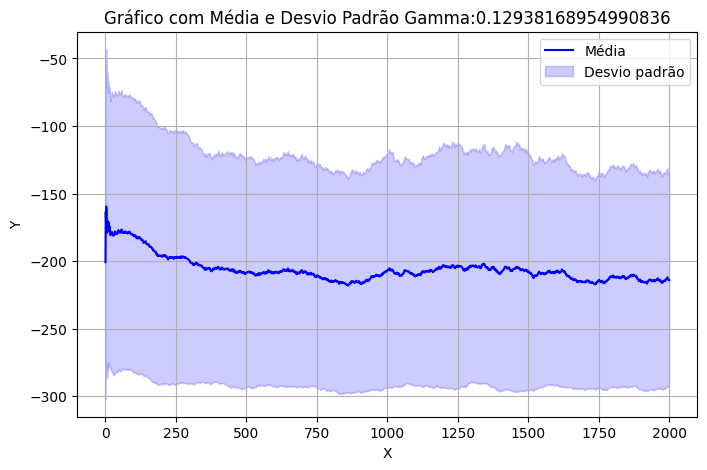

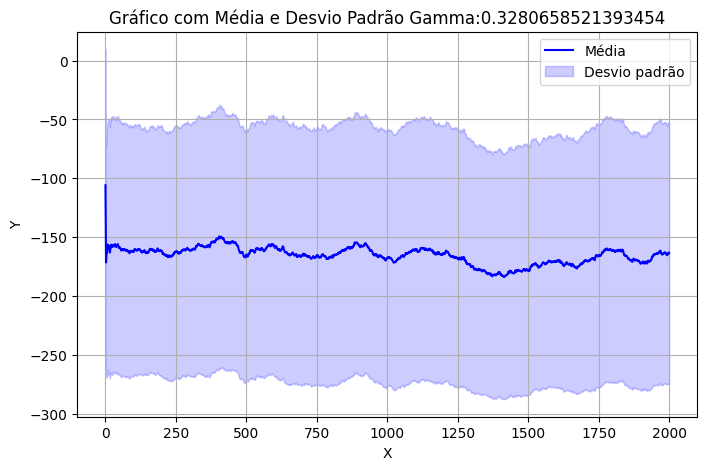

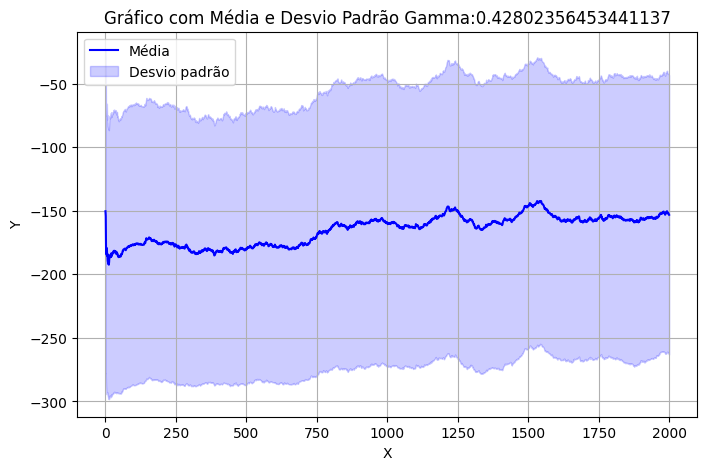

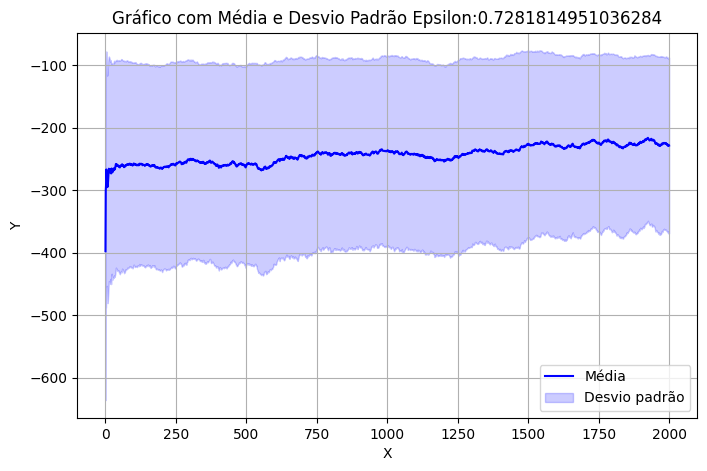

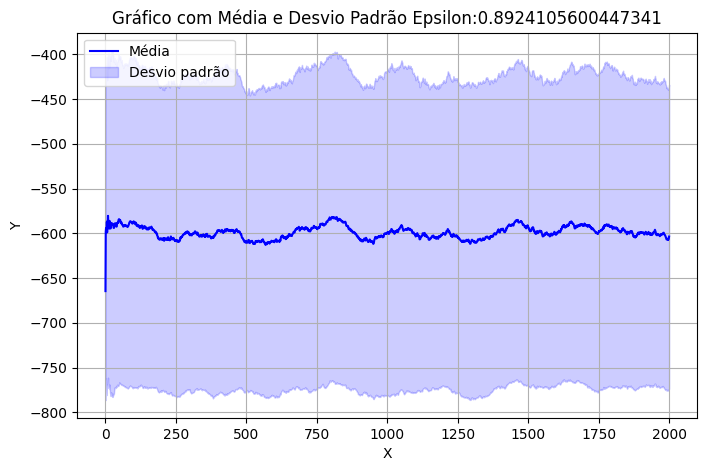

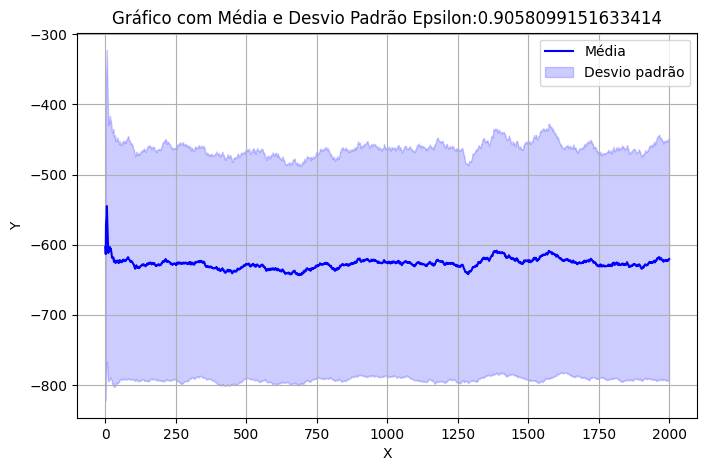

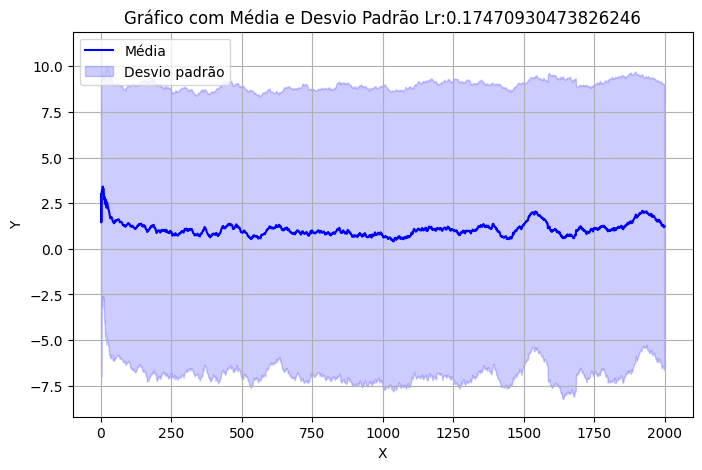

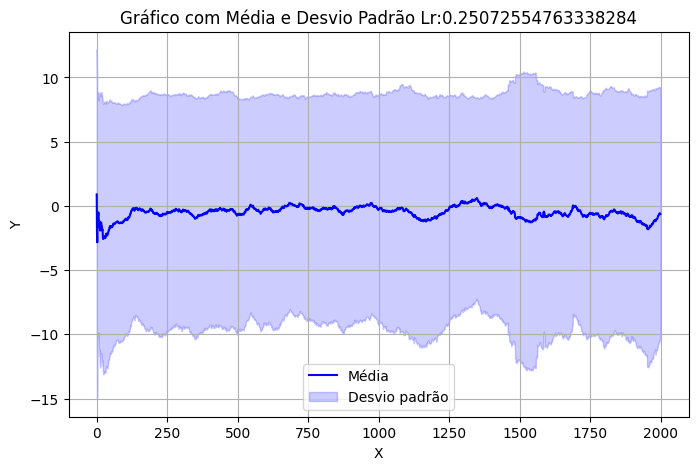

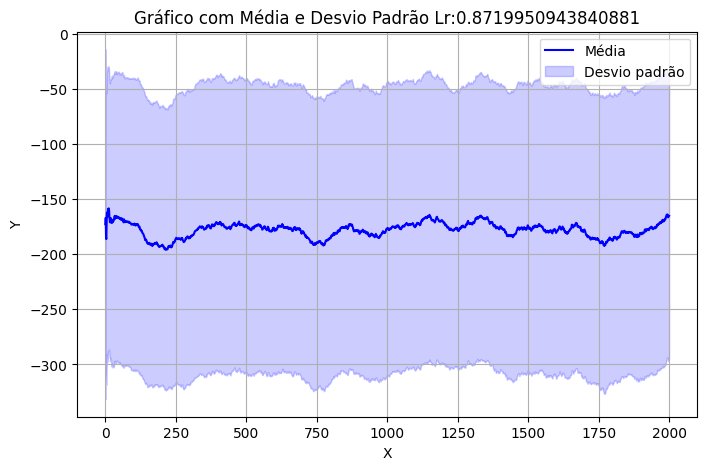

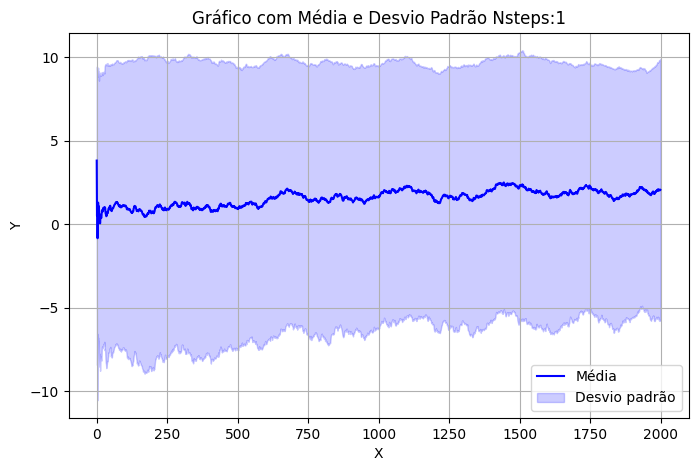

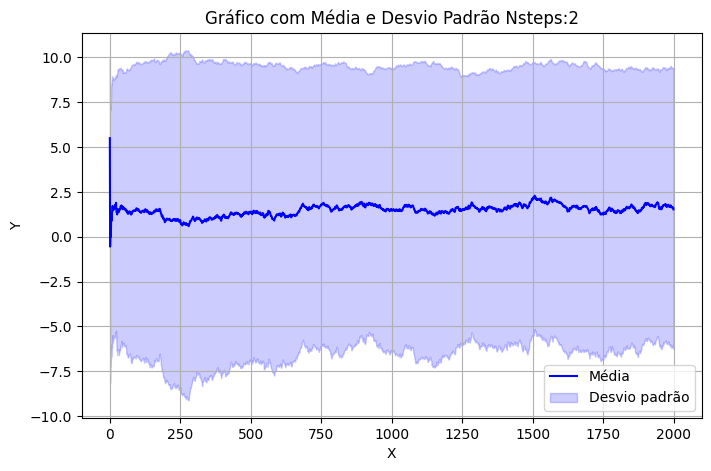

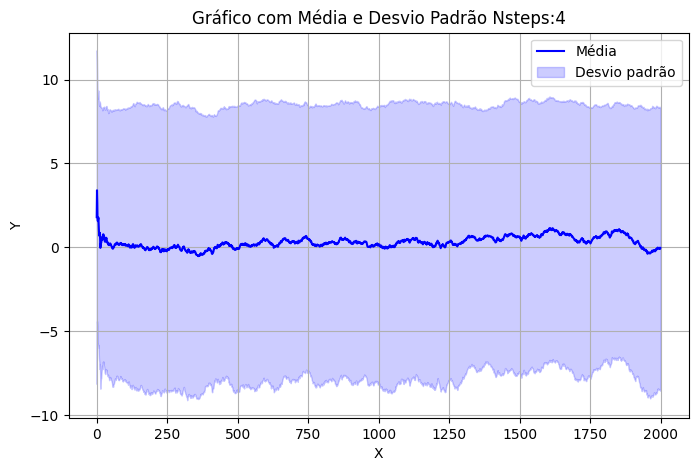

In [ ]:
ENV_NAME, r_max = "Taxi-v3", 10

ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 2_000
EPISODES_TEST = 1_0

# Hyperparameters quando eles não são o foco do estudo
NSTEPS = 3
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)
gama, epsilon, lr, nsteps = experiment(env, ENV_NAME, 100, 'taxi-v2')

## Fim do Projeto




### Código legado

In [ ]:
for key, value in rewards_gamma.items():
  print(f"#{key}\t Média:{np.mean(value)}\t\tDesvio Padrão: {np.std(value)}")

#0.10691801259342172	 Média:-112.35		Desvio Padrão: 44.39850785780982
#0.7567121610904911	 Média:-126.25		Desvio Padrão: 40.44363361519338
#0.2701062105859774	 Média:-120.2		Desvio Padrão: 36.289943510565024
#0.5880488108372625	 Média:-142.0		Desvio Padrão: 18.365728953678914
#0.8191887518623385	 Média:-126.0		Desvio Padrão: 40.65587288449235
#0.5698948091687034	 Média:-110.6		Desvio Padrão: 42.687703147393634
#0.6759190945123904	 Média:-110.35		Desvio Padrão: 42.490322427583436
#0.11335524548805287	 Média:-127.25		Desvio Padrão: 38.39905597797946
#0.7456100466078105	 Média:-134.05		Desvio Padrão: 26.369442542458117
#0.635376612995947	 Média:-122.2		Desvio Padrão: 42.011427016943856


In [ ]:
rewards_nsteps = vary_nsteps(env, NSTEPS_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR, GAMMA=GAMMA, EPSILON=EPSILON, verbose=False, EPISODES=EPISODES)

In [ ]:
for key, value in rewards_nsteps.items():
  print(f"#{key}\t Média:{np.mean(value)}\t\tDesvio Padrão: {np.std(value)}")

#1	 Média:-118.8		Desvio Padrão: 44.041571270789156
#2	 Média:-93.85		Desvio Padrão: 42.86639126401942
#4	 Média:-119.3		Desvio Padrão: 43.1
#8	 Média:-134.1		Desvio Padrão: 35.60182579587738
#16	 Média:-138.35		Desvio Padrão: 26.025516325329647
#32	 Média:-122.4		Desvio Padrão: 45.52845264227635
#64	 Média:-142.3		Desvio Padrão: 23.46294951620533
#128	 Média:-140.15		Desvio Padrão: 28.282989587382726
#256	 Média:-135.15		Desvio Padrão: 26.981984730556793
#512	 Média:-133.2		Desvio Padrão: 34.52622191899948


In [ ]:
rewards_lr = vary_LR(env, LR_RAND, ITERATIONS_TO_CALCULATE_MEAN, GAMMA=GAMMA, EPSILON=EPSILON, verbose=True, EPISODES=EPISODES, NSTEPS=NSTEPS)

In [ ]:
for key, value in rewards_lr.items():
  print(f"#{key}\t Média:{np.mean(value)}\t\tDesvio Padrão: {np.std(value)}")

#0.7414197005512627	 Média:-124.65		Desvio Padrão: 34.84146236885014
#0.980994323727853	 Média:-126.45		Desvio Padrão: 34.43904034667633
#0.39459496814603645	 Média:-140.0		Desvio Padrão: 20.24598725673806
#0.9514998040758166	 Média:-129.45		Desvio Padrão: 33.7245830218848
#0.6917801118404305	 Média:-128.3		Desvio Padrão: 34.17908717329941
#0.41153183218705347	 Média:-116.15		Desvio Padrão: 41.27502271350072
#0.6895801178068364	 Média:-110.45		Desvio Padrão: 39.49110659376362
#0.13291738840305725	 Média:-135.6		Desvio Padrão: 28.24606167238187
#0.5624237690423813	 Média:-130.55		Desvio Padrão: 26.53389341954927
#0.41995191781471664	 Média:-124.65		Desvio Padrão: 40.50589463275685


In [ ]:
rewards_epsilon = vary_EPSILON(env, EPSILON_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR,GAMMA=GAMMA, verbose=True, EPISODES=EPISODES, NSTEPS=NSTEPS)

In [ ]:
for key, value in rewards_epsilon.items():
  print(f"#{key}\t Média:{np.mean(value)}\t\tDesvio Padrão: {np.std(value)}")

#0.17406257093718114	 Média:-127.45		Desvio Padrão: 39.30582017971384
#0.48979584093646134	 Média:-110.55		Desvio Padrão: 48.08999376169641
#0.6053902548245806	 Média:-144.05		Desvio Padrão: 11.355505272774083
#0.21347623688434325	 Média:-123.45		Desvio Padrão: 31.853531986264883
#0.7926663288199893	 Média:-118.05		Desvio Padrão: 43.23710790513168
#0.9298904795823542	 Média:-121.65		Desvio Padrão: 36.904301917256205
#0.24862326088860406	 Média:-104.8		Desvio Padrão: 42.9902314485512
#0.6987369822818559	 Média:-123.95		Desvio Padrão: 40.54192274670751
#0.595112916305213	 Média:-131.3		Desvio Padrão: 30.990482409927083
#0.6343862394641873	 Média:-114.65		Desvio Padrão: 44.386118325440435


In [ ]:
# para ambientes gymnasium
#ENV_NAME, r_max = "Taxi-v3", 10
# ENV_NAME, r_max = "CliffWalking-v0", 0
# ENV_NAME, r_max = "FrozenLake-v1", 0
ENV_NAME, r_max = "RaceTrack-v0", 0

env = gym.make(ENV_NAME)


ITERATIONS_TO_CALCULATE_MEAN = 10
EPISODES = 2_000
EPISODES_TEST = 1_0

# Hyperparameters quando eles não são o foco do estudo
NSTEPS = 3
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1

# Listas de Hyperparameters para que sejam executados os testes.
NSTEPS_RAND = [2**x for x in range(3)]
LR_RAND = np.random.uniform(low=0.1, high=1.0, size=(3,))
EPSILON_RAND = np.random.uniform(low=0.1, high=1.0, size=(3,))
GAMMA_RAND = np.random.uniform(low=0.1, high=0.95, size=(3,))

In [ ]:
rewards_gamma = vary_GAMMA(env, GAMMA_RAND, ITERATIONS_TO_CALCULATE_MEAN, LR=LR, EPSILON=EPSILON, verbose=True, EPISODES=EPISODES, NSTEPS=NSTEPS)

1
Rodando experimento 2 de 0.3280658521393454 passos
Episode 100 Average Reward (last 100): -88.120
Episode 200 Average Reward (last 100): -82.370
Episode 300 Average Reward (last 100): -78.540
Episode 400 Average Reward (last 100): -82.950
Episode 500 Average Reward (last 100): -89.600
Episode 600 Average Reward (last 100): -85.350
Episode 700 Average Reward (last 100): -81.490
Episode 800 Average Reward (last 100): -82.680
Episode 900 Average Reward (last 100): -82.150


KeyboardInterrupt: 